In [1]:
import time
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import yaml
from utils.data_preprocessor import DataPreprocessor

In [2]:
with open('config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

training_file_path: str = "data/AAPL_time_series.csv"
testing_file_path: str = "data/AMZN_time_series.csv"

train_df = pd.read_csv(training_file_path)
test_df = pd.read_csv(testing_file_path)

validation_size: float = 0.2
lookback_period: int = config["data"]["lookback_period"]
target_column: str = config["data"]["target_column"]

training_processor = DataPreprocessor(train_df,lookback_period, target_column, validation_size)
test_processor = DataPreprocessor(test_df, lookback_period, target_column, validation_size)

X = training_processor.X_batched
y = training_processor.y_batched

X_train = training_processor.X_train_scaled
y_train = training_processor.y_train_split
X_val = training_processor.X_validation_scaled
y_val = training_processor.y_validation_split
X_test = test_processor.X_testing_scaled
y_test = test_processor.y_batched

print("Training Dataset shape:", train_df.shape)
print("Testing Dataset shape:", test_df.shape)
print("Dataset as time series batches:",X.shape, y.shape)
print("Training sets shape:", X_train.shape, y_train.shape)
print("Validation sets shape:", X_val.shape, y_val.shape)
print("Testing Dataset as time series batches:",X_test.shape, y_test.shape)

Training Dataset shape: (5000, 30)
Testing Dataset shape: (5000, 30)
Dataset as time series batches: (4970, 20, 30) (4970,)
Training sets shape: (3976, 20, 30) (3976,)
Validation sets shape: (994, 20, 30) (994,)
Testing Dataset as time series batches: (4970, 20, 30) (4970,)


In [3]:
from keras.src.layers import LSTM, Dropout, Dense
from keras import Sequential

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

start_time = time.time()
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_val, y_val), callbacks=[early_stopping])
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Epoch 1/50
497/497 [==============================] - 5s 6ms/step - loss: 0.6786 - accuracy: 0.5717 - val_loss: 0.6202 - val_accuracy: 0.7928
Epoch 2/50
497/497 [==============================] - 3s 5ms/step - loss: 0.5920 - accuracy: 0.7130 - val_loss: 0.5486 - val_accuracy: 0.7797
Epoch 3/50
497/497 [==============================] - 3s 5ms/step - loss: 0.5391 - accuracy: 0.7550 - val_loss: 0.4989 - val_accuracy: 0.7907
Epoch 4/50
497/497 [==============================] - 3s 5ms/step - loss: 0.4960 - accuracy: 0.7882 - val_loss: 0.4544 - val_accuracy: 0.8099
Epoch 5/50
497/497 [==============================] - 3s 5ms/step - loss: 0.4542 - accuracy: 0.8121 - val_loss: 0.4095 - val_accuracy: 0.8350
Epoch 6/50
497/497 [==============================] - 3s 5ms/step - loss: 0.4171 - accuracy: 0.8355 - val_loss: 0.3733 - val_accuracy: 0.8491
Epoch 7/50
497/497 [==============================] - 3s 5ms/step - loss: 0.3784 - accuracy: 0.8544 - val_loss: 0.3390 - val_accuracy: 0.8571
Epoch 

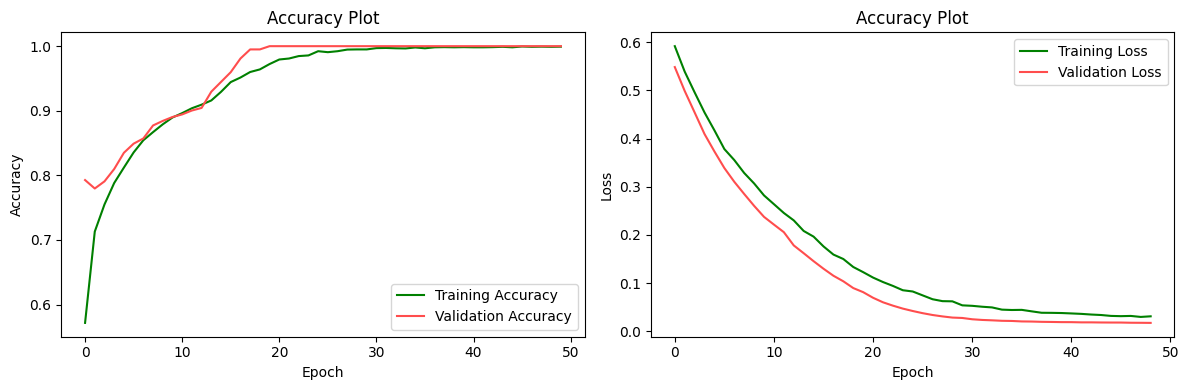

In [4]:
from utils.visualizing_service import plot_model_accuracy
plot_model_accuracy(history)

In [5]:
from collections import Counter

test_loss, test_accuracy = model.evaluate(X_test, y_test)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"Test Loss: {test_loss:.4f}, \nTest Accuracy: {test_accuracy * 100:.2f}%")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

y_actual = y_test
element_counts = Counter(y_actual)

for element, count in element_counts.items():
    print(f"{element}: {count} occurrences")

results_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred.flatten(), 'Predicted_Prob': y_pred_prob.flatten()})
results_df

156/156 [==============================] - 1s 3ms/step
Test Loss: 0.0176, 
Test Accuracy: 100.00%
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC-ROC: 1.0000
1: 2692 occurrences
0: 2278 occurrences


,Actual,Predicted,Predicted_Prob
0,1,1,0.999823
1,1,1,0.999853
2,1,1,0.999840
3,1,1,0.999859
4,1,1,0.999851
5,1,1,0.999631
6,0,0,0.011998
7,0,0,0.001480
8,0,0,0.000790
9,0,0,0.000502


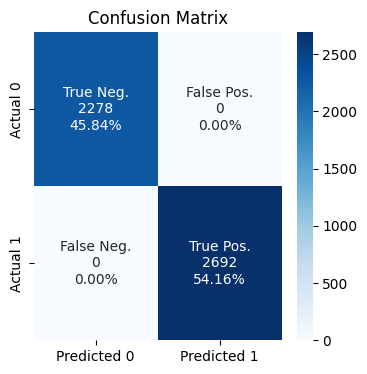

In [6]:
from utils.visualizing_service import plot_confusion_matrix
plot_confusion_matrix(y_test, y_pred)